In [ ]:
"""
@Josh Boquiren
OTIS Lab MUSC
1.21.2023
"""

"""
TO-DO:
- make file for indexing neurons with their clusters
- run analysis for active and inactive inclusive of lever press criteria
- run analysis based on sex
"""

## Population Analysis

In [1]:
#import libraries

#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples


In [2]:
#initialize directories

population = 'ACQUISITION'

basedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data'

earlybasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/EarlyAcq'
middlebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data/MidAcq'
latebasedir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\LateAcq'

models = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\universal_models'
results = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\acquisition\results'

#cluster list files
early_newlabels = np.load(os.path.join(earlybasedir, 'cluster_list_per_session_Acquisition.npy')) #put clustering files in a folder to loop through
middle_newlabels = np.load(os.path.join(middlebasedir, 'cluster_list_per_session_Acquisition.npy'))
late_newlabels = np.load(os.path.join(latebasedir, 'cluster_list_per_session_Acquisition.npy'))

#for later plot titles
plot_titles = ['EARLY', 'MIDDLE', 'LATE']
population_title = "ACQ"

#animals of interest
early_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_of_interest = [
    'CTL1',

    'ER-L1', #FIXME - only 1 inactive press frame recorded
    'ER-L2',

    'IG-19',

    'LCDD-PGa1', #FIXME - only 1 inactive press frame recorded
    'LCDD-PGa3',
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'LCDD-PGa-T1',
    'LCDD-PGa-T2', #FIXME - only 1 inactive press frame recorded
    'LCDD-PGa-T3',
    'LCDD-PGa-T4',
    'LCDD-PGa-T5',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3'
    ]  
late_animals_of_interest = [
    'CTL1',

    'ER-L1',
    'ER-L2',

    'IG-19',

    'LCDD-PGa1',
    'LCDD-PGa3', 
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'LCDD-PGa-T1',
    'LCDD-PGa-T2',
    'LCDD-PGa-T3',
    'LCDD-PGa-T4',
    'LCDD-PGa-T5',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3' #FIXME
    ]  

In [3]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate
print('Frame rate:', framerate)
print('Averaged frame rate:', averagedframerate)

#window size variables
pre_window_size = int(10*framerate) #How many frames per trial before origin to be plotted?
window_size =  int((pre_window_size*2)+(3*framerate)) #How many frames do you want to plot around the origin?
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))
print('Prewindow size:', pre_window_size)
print('Window size:', window_size)
print('Postwindow size:', post_window_size)

#set cell tracking
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes
csv_id_for_tracking = 'CUE-DRUG-TMT'

#tracking
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

Frame rate: 8.333325
Averaged frame rate: 8.333325
Prewindow size: 83
Window size: 190
Postwindow size: 107
No Cell Tracking


### Preprocessing

In [ ]:
#method for fixing dropped frames
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

#method for fixing assumed frames
def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

#generate behavior data
try:
    assumed_frames = np.load(os.path.join(models, 'assumed_frames.npy'))
    assumed_frame_timestamps = np.load(os.path.join(models, 'assumed_frame_timestamps.npy'))
    print("Loaded behavior data.")
except:
    #load in data
    behaviordata_noframes = sio.loadmat(r"C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\Spreadsheets\matfile_noframes_3.mat")
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    #parse desired data
    max_of_eventlog_noframes = max(eventlog_noframes[:,1]) #all rows, second column
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)
    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

    np.save(os.path.join(models, 'assumed_frames'), assumed_frames)
    np.save(os.path.join(models, 'assumed_frame_timestamps'), assumed_frame_timestamps)
    print("Behavior data processed and loaded.")


In [ ]:
#various methods

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2


def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        #print('     e:', e)
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function ipltements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [ ]:
#method for animal analysis
def analyze_single_session(indir, window_size, pre_window_size):    
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        if npyfile[0][0]!='nan':
            npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numneurons = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        if signals2[0][0]!='nan':
            signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        if signals3[0][0]!='nan':
            signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        if signals4[0][0]!='nan':
            signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    #pulling data from eventlog
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]    

    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T






    
    
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1]) 
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
        
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    
    seconds_monitored = int(signals.shape[1]/averagedframerate) ###seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) ###final seconds to be monitored for behavior

    if seconds_monitored < seconds_behavior: #calculates last fully-monitored active lever press with 2p recording
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i]) #FIXME why is this even here?
        activelever=included_trials 
    #combines all presses
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))

    #FIXME
    if activeleverall.shape[0] < 6:
        activeleverall =np.array([])
    if inactiveleverall.shape[0] < 6:
        inactiveleverall = np.array([])
    print('Signals.T:', signalsT.shape, 'Active:', activeleverall.shape, 'Inactive:',inactiveleverall.shape )
 
    #method for calculating aligned data
    def calculate_aligneddata_forevent(data, frame_after_event): #FIXME
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numneurons])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numneurons])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            print(i)
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                print('  tempindex',tempindex)
                print('  tempstartindex',tempstartindex)
                print('  startindex',startindex)
                print('  tempendindex',tempendindex)
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    #endindex = np.amin([framenumberfor_eventofinterest[i+1]-tempindex, tempendindex]).astype(int)
                    #print('  endindex', endindex)
                    endindex = tempendindex
                    print('  endindex', endindex)
                else:
                    #endindex = tempendindex.astype(int) 
                    endindex = tempendindex
                    print('  endindex', endindex) 
                    prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    print('     T1 align to plot:', (align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:]).shape)
                    print('     T2 temp:', (temp[tempindex-startindex:tempindex+endindex,:]).shape) #FIXME -> throwing index error
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    print((align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:]).shape)
                    print((temp[tempindex-startindex:tempindex+endindex,:]).shape)
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numneurons))
                    align[i,:,:] = np.nan*np.ones((window_size, numneurons))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))
        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
        return align, align_to_plot, framenumberfor_eventofinterest
    
    print('start active calculation')
    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
    print('end active calculation')

    print('start inactive calculation')
    align_inactivelever, align_to_plot_inactivelever, framenumberfor_frameafter_inactivelever = \
        calculate_aligneddata_forevent(signalsT, inactiveleverall) #FIXME
    populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1
    print('end inactive calculation')
    
    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
        
    return populationdata_activelever, populationdata_inactivelever, align_activelever, align_inactivelever, framerate

#### Making single session analysis files

In [ ]:
#Early population
excluded = []
for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp_active = np.nan*np.ones((1, window_size))
        temp_inactive = np.nan*np.ones((1, window_size))
        for fov in sorted(FOVs):
            try:
                temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                    #analysis parameters
                    os.path.join(earlybasedir, animal, fov), 
                    window_size, 
                    pre_window_size
                    )
                #saving active and inactive signal data (includig NaN rows)
                temp_active = np.vstack((temp_active, temp1))
                temp_inactive = np.vstack((temp_inactive, temp2))
                #saving aligned active and inactive lever data
                temp_align_active_lever = temp3
                temp_align_inactive_lever = temp4
            except Exception as e:
                print('***ERROR:', e, '***')
                excluded.append(animal)
            #files for signal data with NaN's
            np.save(os.path.join(earlybasedir, animal, fov, "active"), temp_active[1:,:])
            np.save(os.path.join(earlybasedir, animal, fov, "inactive"), temp_inactive[1:,:])
            #files for aligned lever data
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Early excluded animals:', excluded)

In [ ]:
#Middle population
excluded = []
for animal in middle_animals_of_interest:
    print('\n>>>', animal)
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
            temp_active = np.nan*np.ones((1, window_size))
            temp_inactive = np.nan*np.ones((1, window_size))
            try:
                for fov in sorted(FOVs):
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(middlebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active and inactive signal data (includig NaN rows)
                    temp_active = np.vstack((temp_active, temp1))
                    temp_inactive = np.vstack((temp_inactive, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
            except Exception as e:
                    print('***ERROR:', e, '***')
                    excluded.append(animal)
            #files for signal data without NaN's
            np.save(os.path.join(middlebasedir, animal, fov, "active"), temp_active[1:,:])
            np.save(os.path.join(middlebasedir, animal, fov, "inactive"), temp_inactive[1:,:])
            #files for aligned lever data
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
            np.save(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Middle excluded animals:', excluded)

In [ ]:
#Late population
excluded = []
for animal in late_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
            temp_active = np.nan*np.ones((1, window_size))
            temp_inactive = np.nan*np.ones((1, window_size))
            for fov in sorted(FOVs):
                try:
                    temp1, temp2, temp3, temp4, framerate = analyze_single_session(
                        #analysis parameters
                        os.path.join(latebasedir, animal, fov), 
                        window_size, 
                        pre_window_size
                        )
                    #saving active and inactive signal data (includig NaN rows)
                    print('Temp active shape:', temp_active.shape, 'Temp1 shape:', temp1.shape)
                    temp_active = np.vstack((temp_active, temp1))
                    temp_inactive = np.vstack((temp_inactive, temp2))
                    #saving aligned active and inactive lever data
                    temp_align_active_lever = temp3
                    temp_align_inactive_lever = temp4
                except Exception as e:
                    print('***ERROR:', e, '***')
                    excluded.append(animal)
                #files for signal data without NaN's
                np.save(os.path.join(latebasedir, animal, fov, "active"), temp_active[1:,:])
                np.save(os.path.join(latebasedir, animal, fov, "inactive"), temp_inactive[1:,:])
                #files for aligned lever data
                np.save(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data"), temp_align_active_lever)
                np.save(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data"), temp_align_inactive_lever)
print('Late excluded animals:', excluded)

In [ ]:
#checking shapes of files

temp_arr = []

for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(earlybasedir, animal, fov, "active.npy"))
                inactive = np.load(os.path.join(earlybasedir, animal, fov, "inactive.npy"))
                aligned_active_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'EARLY',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(middlebasedir, animal, fov, "active.npy"))
                inactive = np.load(os.path.join(middlebasedir, animal, fov, "inactive.npy"))
                aligned_active_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'MIDDLE',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        #load in data
        try:
                active_data = np.load(os.path.join(latebasedir, animal, fov, "active.npy"))
                inactive = np.load(os.path.join(latebasedir, animal, fov, "inactive.npy"))
                aligned_active_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data.npy"))
                aligned_inactive_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_inactive_lever_data.npy"))
                temp_dict = {
                    'Animal': animal,
                    'Day': 'LATE',
                    'Active shape': active_data.shape,
                    'Inactive shape': inactive.shape,
                    'Aligned active shape': aligned_active_lever_data.shape,
                    'Aligned inactive shape': aligned_inactive_lever_data.shape
                }
                temp_arr.append(temp_dict)
        except:
               print('***ERROR: no files!***')

animal_df = pd.DataFrame(temp_arr)
animal_df

### Stacking data

#### All population data

In [4]:
#method for stacking data
def stack_data(indir, animals_of_interest, window, signals_file, aligned_levers_file):
    temp_data = np.nan*np.ones((1, window))
    for animal in animals_of_interest:
            FOVs = next(os.walk(os.path.join(indir, animal)))[1]
            for fov in sorted(FOVs):
                    try:
                        #load in data
                        signal_data = np.load(os.path.join(indir, animal, fov, signals_file))
                        lever_data = np.load(os.path.join(indir, animal, fov, aligned_levers_file))
                        #stack data
                        temp_data = np.vstack((temp_data, signal_data))
                    except Exception as e:
                        print('***ERROR:', e, ' ***')
    data = temp_data[1:,:]
    return(data, lever_data)

In [14]:
#method for matching neurons to clusters based on criteria
def find_indexes(indir, sub_animals_of_interest_array, original_full_stack, signal_file, cluster_labels_file):
    indexes = []
    for animal in sub_animals_of_interest_array:
        FOVs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(FOVs):
            signal_data = np.load(os.path.join(indir, animal, fov, signal_file))
            for neuron in range(len(signal_data)):
                for row in range(len(original_full_stack)):
                    if np.equal(signal_data[neuron], original_full_stack[row])[0]==True:
                        indexes.append({'Animal': animal, 'Stack index': row, 'Cluster': cluster_labels_file[row]})
    indexes = pd.DataFrame(indexes)
    return(indexes)

In [5]:
#stacking early data

#early active data
temp_early_active, early_active_levers = stack_data(earlybasedir, early_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons
numneurons_early_active = temp_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
early_active = temp_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_active_mean = np.nanmean(early_active, axis=0)


#early inactive data
temp_early_inactive, early_inactive_levers = stack_data(earlybasedir, early_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons
numneurons_early_inactive = temp_early_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
early_inactive = temp_early_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_inactive_mean = np.nanmean(early_inactive, axis=0)

print('Active shape:', early_active.shape)
print('Active lever shape:', early_active_levers.shape)
print('Inative shape:', early_inactive.shape)
print('Inctive lever shape:', early_inactive_levers.shape)

Active shape: (2392, 190)
Active lever shape: (14, 190, 117)
Inative shape: (2392, 190)
Inctive lever shape: (49, 190, 117)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_20624\2332505228.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(early_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


In [6]:
#stacking middle data

#middle active data
temp_middle_active, middle_active_levers = stack_data(middlebasedir, middle_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons is length of data
numneurons_middle_active = temp_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
middle_active = temp_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
middle_active_mean = np.nanmean(middle_active, axis=0)


#middle inactive data
temp_middle_inactive, middle_inactive_levers = stack_data(middlebasedir, middle_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons is length of data
numneurons_middle_inactive = temp_middle_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
middle_inactive = temp_middle_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
middle_inactive_mean = np.nanmean(middle_inactive, axis=0)

print('Active shape:', middle_active.shape)
print('Active lever shape:', middle_active_levers.shape)
print('Inative shape:', middle_inactive.shape)
print('Inctive lever shape:', middle_inactive_levers.shape)

Active shape: (2592, 190)
Active lever shape: (170, 190, 171)
Inative shape: (2592, 190)
Inctive lever shape: (373, 190, 171)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_20624\6816291.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(middle_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


In [15]:
#stacking late data

#late active data
temp_late_active, late_active_levers = stack_data(latebasedir, late_animals_of_interest, window_size, "active.npy", 'aligned_active_lever_data.npy')

#num neurons is length of data
numneurons_late_active = temp_late_active.shape[0]-1 

#calculating population data - baseline
baseline = np.mean(temp_late_active[:,baselinefirstframe:baselinelastframe], axis=1)
late_active = temp_late_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
late_active_mean = np.nanmean(late_active, axis=0)


#late inactive data
temp_late_inactive, late_inactive_levers = stack_data(latebasedir, late_animals_of_interest, window_size, "inactive.npy", 'aligned_inactive_lever_data.npy')

#num neurons is length of data
numneurons_late_inactive = temp_late_inactive.shape[0]-1 

#calculating population data - baseline
baseline = np.mean(temp_late_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
late_inactive = temp_late_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
late_inactive_mean = np.nanmean(late_inactive, axis=0)

print('Active shape:', late_active.shape)
print('Active lever shape:', late_active_levers.shape)
print('Inative shape:', late_inactive.shape)
print('Inctive lever shape:', late_inactive_levers.shape)

Active shape: (2237, 190)
Active lever shape: (149, 190, 145)
Inative shape: (2237, 190)
Inctive lever shape: (10, 190, 145)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_20624\891527901.py:32: RuntimeWarning: Mean of empty slice
  tempresponse = np.nanmean(late_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)


#### Population data based on lever presses

In [16]:
#creating array of animals that meet lever press requirement

req_presses = 6

#early animals
sub_early = []
for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        lever_data = np.load(os.path.join(earlybasedir, animal, fov, 'aligned_inactive_lever_data.npy'))
        num_presses = lever_data.shape[0]
        if num_presses > req_presses:
            sub_early.append(animal)

#middle animals
sub_middle = []
for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        lever_data = np.load(os.path.join(middlebasedir, animal, fov, 'aligned_inactive_lever_data.npy'))
        num_presses = lever_data.shape[0]
        if num_presses > req_presses:
            sub_middle.append(animal)

#late animals
sub_late = []
for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        lever_data = np.load(os.path.join(latebasedir, animal, fov, 'aligned_inactive_lever_data.npy'))
        num_presses = lever_data.shape[0]
        if num_presses > req_presses:
            sub_late.append(animal)

print('Early animals with sufficient presses:', sub_early)
print('Middle animals with sufficient presses:', sub_middle)
print('Late animals with sufficient presses:', sub_late)


Early animals with sufficient presses: ['CTL1', 'PGa-T1', 'PGa-T2', 'PGa-T3']
Middle animals with sufficient presses: ['CTL1', 'IG-19', 'LCDD-PGa3', 'LCDD-PGa5', 'PGa-T1', 'PGa-T2', 'PGa-T3']
Late animals with sufficient presses: ['PGa-T3']


In [33]:
#early data

#dataframe of female animal active data indexes
sub_early_active_df = find_indexes(earlybasedir, sub_early, temp_early_active, 'active.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in sub_early_active_df['Stack index']:
    temp_stack = np.vstack((temp_stack, early_active[index]))
sub_early_active = temp_stack[1:,:]

#num neurons
numneurons_sub_early_active = sub_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(sub_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
sub_early_active_minus_baseline = sub_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(sub_early_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_sub_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
sub_early_active_mean = np.nanmean(sub_early_active, axis=0)



#dataframe of female animal active data indexes
sub_early_inactive_df = find_indexes(earlybasedir, sub_early, temp_early_inactive, 'inactive.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in sub_early_inactive_df['Stack index']:
    temp_stack = np.vstack((temp_stack, early_inactive[index]))
sub_early_inactive = temp_stack[1:,:]

#num neurons
numneurons_sub_early_inactive = sub_early_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(sub_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
sub_early_inactive_minus_baseline = sub_early_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(sub_early_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_sub_early_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
sub_early_inactive_mean = np.nanmean(sub_early_inactive, axis=0)

In [34]:
#middle data

#dataframe of female animal active data indexes
sub_middle_active_df = find_indexes(middlebasedir, sub_middle, temp_middle_active, 'active.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in sub_middle_active_df['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_active[index]))
sub_middle_active = temp_stack[1:,:]

#num neurons
numneurons_sub_middle_active = sub_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(sub_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
sub_middle_active_minus_baseline = sub_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(sub_middle_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_sub_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
sub_middle_active_mean = np.nanmean(sub_middle_active, axis=0)



#dataframe of female animal active data indexes
sub_middle_inactive_df = find_indexes(middlebasedir, sub_middle, temp_middle_inactive, 'inactive.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in sub_middle_inactive_df['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_inactive[index]))
sub_middle_inactive = temp_stack[1:,:]

#num neurons
numneurons_sub_middle_inactive = sub_middle_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(sub_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
sub_middle_inactive_minus_baseline = sub_middle_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(sub_middle_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_sub_middle_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
sub_middle_inactive_mean = np.nanmean(sub_middle_inactive, axis=0)

In [35]:
#late data

#dataframe of female animal active data indexes
sub_late_active_df = find_indexes(latebasedir, sub_late, temp_late_active, 'active.npy', late_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in sub_late_active_df['Stack index']:
    temp_stack = np.vstack((temp_stack, late_active[index]))
sub_late_active = temp_stack[1:,:]

#num neurons
numneurons_sub_late_active = sub_late_active.shape[0]

#calculating population data - baseline
baseline = np.mean(sub_late_active[:,baselinefirstframe:baselinelastframe], axis=1)
sub_late_active_minus_baseline = sub_late_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(sub_late_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_sub_late_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
sub_late_active_mean = np.nanmean(sub_late_active, axis=0)



#dataframe of female animal active data indexes
sub_late_inactive_df = find_indexes(latebasedir, sub_late, temp_late_inactive, 'inactive.npy', late_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in sub_late_inactive_df['Stack index']:
    temp_stack = np.vstack((temp_stack, late_inactive[index]))
sub_late_inactive = temp_stack[1:,:]

#num neurons
numneurons_sub_late_inactive = sub_late_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(sub_late_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
sub_late_inactive_minus_baseline = sub_late_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(sub_late_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_sub_late_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
sub_late_inactive_mean = np.nanmean(sub_late_inactive, axis=0)

#### Female vs. Male data

In [4]:
#separating males and females arrays
females = [
    'CTL1',
    'PGa-T2', 'PGa-T3',
    'LCDD-PGa-T1', 'LCDD-PGa-T2', 'LCDD-PGa-T3',
    'LCDD-PGa6'
    ]

males = [
    'ER-L2',
    'IG-19',
    'LCDD-PGa1', 'LCDD-PGa3', 'LCDD-PGa4', 'LCDD-PGa5',
    'LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1',
    ]



##### Females

In [12]:
#early female data

#dataframe of female animal active data indexes
females_early_active = find_indexes(earlybasedir, females, temp_early_active, 'active.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_early_active['Stack index']:
    temp_stack = np.vstack((temp_stack, early_active[index]))
females_early_active = temp_stack[1:,:]

#num neurons
numneurons_females_early_active = females_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(females_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
females_early_active_minus_baseline = females_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_early_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_early_active_mean = np.nanmean(females_early_active, axis=0)



#dataframe of female animal active data indexes
females_early_inactive = find_indexes(earlybasedir, females, temp_early_inactive, 'inactive.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_early_inactive['Stack index']:
    temp_stack = np.vstack((temp_stack, early_inactive[index]))
females_early_inactive = temp_stack[1:,:]

#num neurons
numneurons_females_early_inactive = females_early_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(females_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
females_early_inactive_minus_baseline = females_early_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_early_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_early_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_early_inactive_mean = np.nanmean(females_early_inactive, axis=0)

NameError: name 'find_indexes' is not defined

In [12]:
#middle female data

#dataframe of female animal active data indexes
females_middle_active = find_indexes(middlebasedir, females, temp_middle_active, 'active.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_middle_active['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_active[index]))
females_middle_active = temp_stack[1:,:]

#num neurons
numneurons_females_middle_active = females_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(females_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
females_middle_active_minus_baseline = females_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_middle_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_middle_active_mean = np.nanmean(females_middle_active, axis=0)



#dataframe of female animal inactive data indexes
females_middle_inactive = find_indexes(middlebasedir, females, temp_middle_inactive, 'inactive.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_middle_inactive['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_inactive[index]))
females_middle_inactive = temp_stack[1:,:]

#num neurons
numneurons_females_middle_inactive = females_middle_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(females_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
females_middle_inactive_minus_baseline = females_middle_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_middle_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_middle_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_middle_inactive_mean = np.nanmean(females_middle_inactive, axis=0)

In [13]:
#late female data

#dataframe of female animal active data indexes
females_late_active = find_indexes(latebasedir, females, temp_late_active, 'active.npy', late_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_late_active['Stack index']:
    temp_stack = np.vstack((temp_stack, late_active[index]))
females_late_active = temp_stack[1:,:]

#num neurons
numneurons_females_late_active = females_late_active.shape[0]

#calculating population data - baseline
baseline = np.mean(females_late_active[:,baselinefirstframe:baselinelastframe], axis=1)
females_late_active_minus_baseline = females_late_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_late_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_late_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_late_active_mean = np.nanmean(females_late_active, axis=0)



#dataframe of female animal inactive data indexes
females_late_inactive = find_indexes(latebasedir, females, temp_late_inactive, 'inactive.npy', late_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in females_late_inactive['Stack index']:
    temp_stack = np.vstack((temp_stack, late_inactive[index]))
females_late_inactive = temp_stack[1:,:]

#num neurons
numneurons_females_late_inactive = females_late_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(females_late_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
females_late_inactive_minus_baseline = females_late_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(females_late_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_females_late_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
females_late_inactive_mean = np.nanmean(females_late_inactive, axis=0)

##### Males

In [14]:
#early male data

#dataframe of male animal active data indexes
males_early_active = find_indexes(earlybasedir, males, temp_early_active, 'active.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_early_active['Stack index']:
    temp_stack = np.vstack((temp_stack, early_active[index]))
males_early_active = temp_stack[1:,:]

#num neurons
numneurons_males_early_active = males_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(males_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
males_early_active_minus_baseline = males_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_early_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_early_active_mean = np.nanmean(males_early_active, axis=0)



#dataframe of male animal active data indexes
males_early_inactive = find_indexes(earlybasedir, males, temp_early_inactive, 'inactive.npy', early_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_early_inactive['Stack index']:
    temp_stack = np.vstack((temp_stack, early_inactive[index]))
males_early_inactive = temp_stack[1:,:]

#num neurons
numneurons_males_early_inactive = males_early_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(males_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
males_early_inactive_minus_baseline = males_early_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_early_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_early_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_early_inactive_mean = np.nanmean(males_early_inactive, axis=0)

In [15]:
#middle male data

#dataframe of male animal active data indexes
males_middle_active = find_indexes(middlebasedir, males, temp_middle_active, 'active.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_middle_active['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_active[index]))
males_middle_active = temp_stack[1:,:]

#num neurons
numneurons_males_middle_active = males_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(males_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
males_middle_active_minus_baseline = males_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_middle_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_middle_active_mean = np.nanmean(males_middle_active, axis=0)



#dataframe of male animal inactive data indexes
males_middle_inactive = find_indexes(middlebasedir, males, temp_middle_inactive, 'inactive.npy', middle_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_middle_inactive['Stack index']:
    temp_stack = np.vstack((temp_stack, middle_inactive[index]))
males_middle_inactive = temp_stack[1:,:]

#num neurons
numneurons_males_middle_inactive = males_middle_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(males_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
males_middle_inactive_minus_baseline = males_middle_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_middle_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_middle_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_middle_inactive_mean = np.nanmean(males_middle_inactive, axis=0)

In [16]:
#late male data

#dataframe of male animal active data indexes
males_late_active = find_indexes(latebasedir, males, temp_late_active, 'active.npy', late_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_late_active['Stack index']:
    temp_stack = np.vstack((temp_stack, late_active[index]))
males_late_active = temp_stack[1:,:]

#num neurons
numneurons_males_late_active = males_late_active.shape[0]

#calculating population data - baseline
baseline = np.mean(males_late_active[:,baselinefirstframe:baselinelastframe], axis=1)
males_late_active_minus_baseline = males_late_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_late_active_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_late_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_late_active_mean = np.nanmean(males_late_active, axis=0)



#dataframe of male animal inactive data indexes
males_late_inactive = find_indexes(latebasedir, males, temp_late_inactive, 'inactive.npy', late_newlabels)

temp_stack = np.nan*np.ones((1, window_size))
for index in males_late_inactive['Stack index']:
    temp_stack = np.vstack((temp_stack, late_inactive[index]))
males_late_inactive = temp_stack[1:,:]

#num neurons
numneurons_males_late_inactive = males_late_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(males_late_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
males_late_inactive_minus_baseline = males_late_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(males_late_inactive_minus_baseline[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_males_late_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
males_late_inactive_mean = np.nanmean(males_late_inactive, axis=0)

### Plots

#### All population data

In [22]:
#filter out the NaN values
def filter_NAN(processed_data, windowsize, prewindowsize, framerate):
        filtered_stack = np.nan*np.ones((1, windowsize))
        for row in processed_data:
                if np.isfinite(row[0]):
                        filtered_stack = np.vstack((filtered_stack, row))
        filtered_stack = filtered_stack[1:,:]
        response = np.nanmean(filtered_stack[:,prewindowsize-(1*int(framerate)):prewindowsize+1*int(framerate)], axis=1)
        sortresponse = np.argsort(response)[::-1]
        return(filtered_stack, sortresponse)

C:\Users\jboqu\AppData\Local\Temp\ipykernel_20624\310160790.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pre_window_size, pre_window_size],


KeyboardInterrupt: 

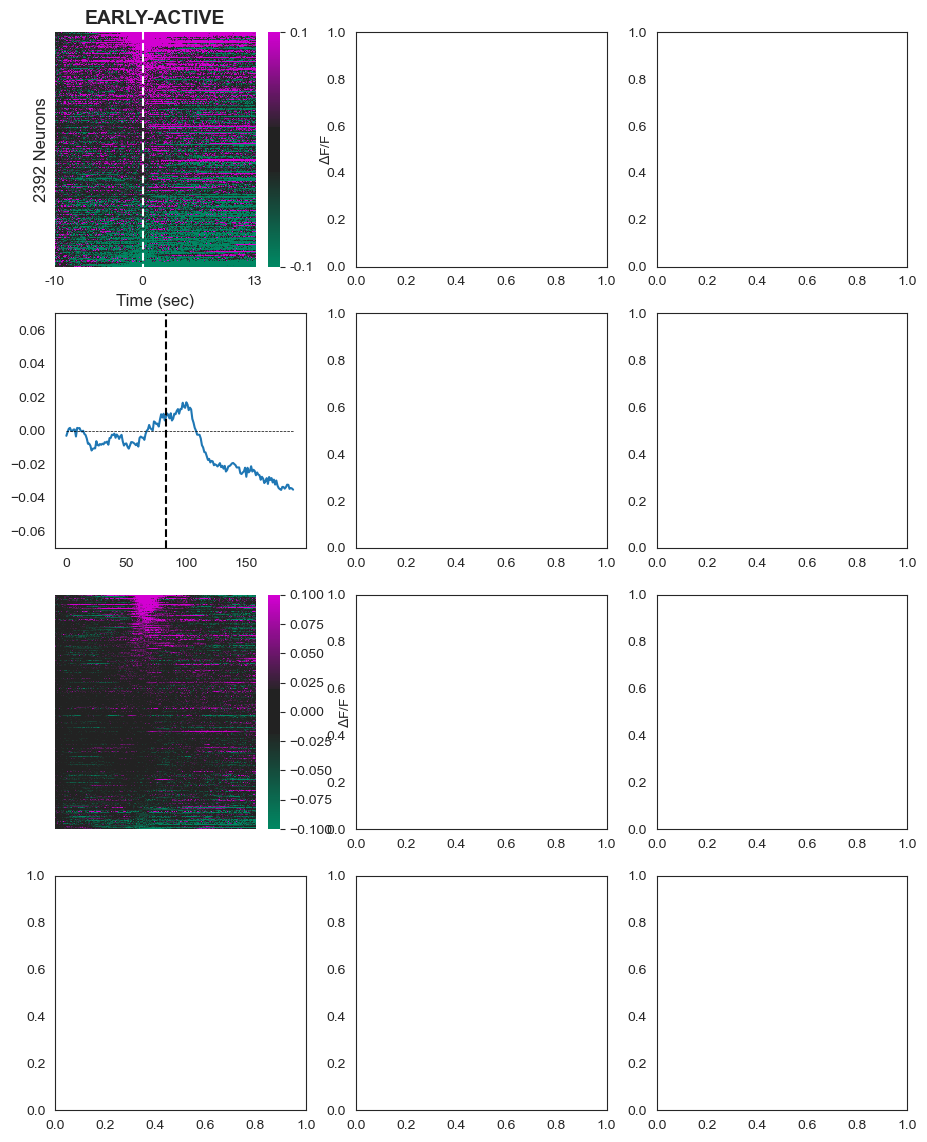

In [23]:
#plot

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(early_active[sortresponse_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[1, 0]
ax.plot(early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# early inactive plots (sorted to active plot)
ax = axs[2, 0]

#filtering NaN's
sorted_early_inactive, inactive_sort = filter_NAN(early_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_early_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_early_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 0]
ax.plot(early_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(middle_active[sortresponse_middle_active, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 1]
ax.plot(middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# middle inactive plots
ax = axs[2, 1]

#filtering NaN's
sorted_middle_inactive, inactive_sort = filter_NAN(middle_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_middle_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_middle_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 1]
ax.plot(middle_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# late active plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(late_active[sortresponse_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_late_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 2]
ax.plot(late_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# late inactive plots
ax = axs[2, 2]

#filtering NaN's
sorted_late_inactive, inactive_sort = filter_NAN(late_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_late_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0", "13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_late_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 2]
ax.plot(late_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')


In [ ]:
#save fig
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-inactive-all_population_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-inactive-all_population_heatmaps.PNG'), format='PNG')

#### Female vs. Male data

C:\Users\jboqu\AppData\Local\Temp\ipykernel_25936\2925834433.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pre_window_size, pre_window_size],


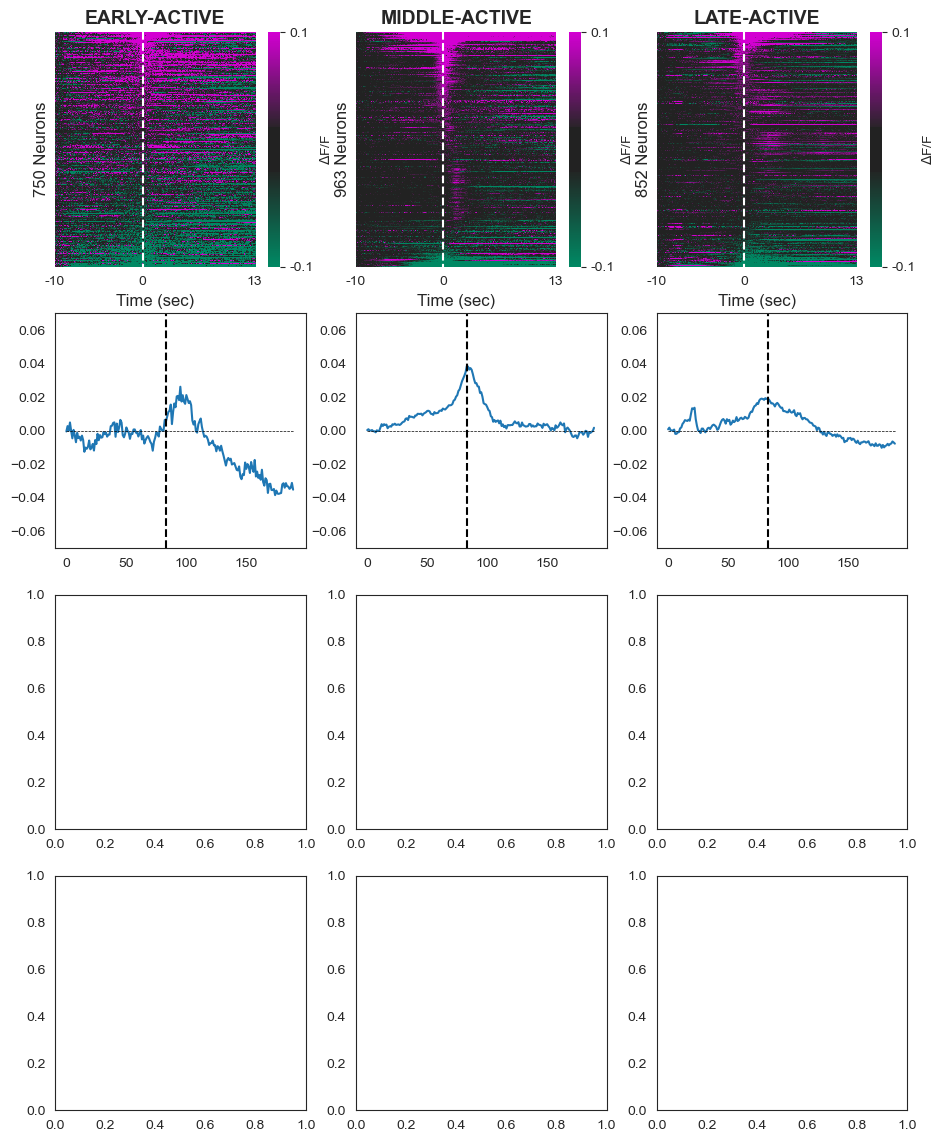

In [20]:
#plot for female active and inactive data

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(females_early_active_minus_baseline[sortresponse_females_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_females_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_females_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[1, 0]
ax.plot(females_early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## early inactive plots (sorted to active plot)
#ax = axs[2, 0]

## heatmap
#hm = sns.heatmap(females_early_inactive_minus_baseline[sortresponse_females_early_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_females_early_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_females_early_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 0]
#ax.plot(females_early_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(females_middle_active_minus_baseline[sortresponse_females_middle_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_females_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_females_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 1]
ax.plot(females_middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## middle inactive plots
#ax = axs[2, 1]

## heatmap
#hm = sns.heatmap(females_middle_inactive_minus_baseline[sortresponse_females_middle_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_females_middle_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_females_middle_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 1]
#ax.plot(females_middle_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

# late active plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(females_late_active_minus_baseline[sortresponse_females_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_females_late_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_females_late_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 2]
ax.plot(females_late_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## late inactive plots
#ax = axs[2, 2]

## heatmap
#hm = sns.heatmap(females_late_inactive_minus_baseline[sortresponse_females_late_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0", "13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_females_late_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_females_late_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 2]
#ax.plot(females_late_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')


In [21]:
FvM_results = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\female-vs-male_analysis\acquisition\results'

#save fig
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Acquisition_female-active_population_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Acquisition_female-active_population_heatmaps.PNG'), format='PNG')

C:\Users\jboqu\AppData\Local\Temp\ipykernel_25936\2108852795.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pre_window_size, pre_window_size],


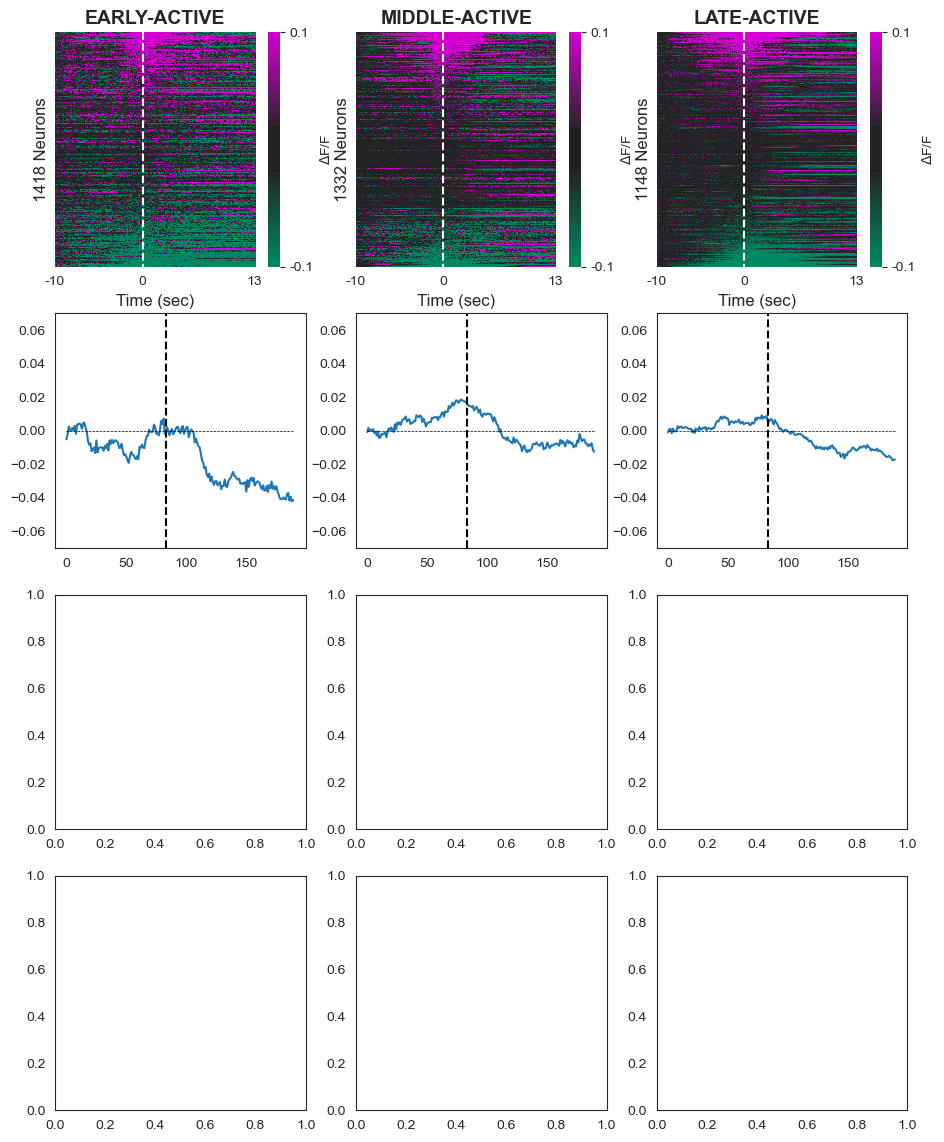

In [22]:
#plot for male active and inactive data

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(males_early_active_minus_baseline[sortresponse_males_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_males_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_males_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[1, 0]
ax.plot(males_early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## early inactive plots (sorted to active plot)
#ax = axs[2, 0]

## heatmap
#hm = sns.heatmap(males_early_inactive_minus_baseline[sortresponse_males_early_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_males_early_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_males_early_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 0]
#ax.plot(males_early_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(males_middle_active_minus_baseline[sortresponse_males_middle_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_males_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_males_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 1]
ax.plot(males_middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## middle inactive plots
#ax = axs[2, 1]

## heatmap
#hm = sns.heatmap(males_middle_inactive_minus_baseline[sortresponse_males_middle_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0","13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_males_middle_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_males_middle_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 1]
#ax.plot(males_middle_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')

# late active plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(males_late_active_minus_baseline[sortresponse_males_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_males_late_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_males_late_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 2]
ax.plot(males_late_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

## late inactive plots
#ax = axs[2, 2]

## heatmap
#hm = sns.heatmap(males_late_inactive_minus_baseline[sortresponse_males_late_inactive,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
#                 cmap=sns.diverging_palette(
#                     154, 308, n=230, s=100, sep=50, center='dark'),
#                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

## colorbar
#cbar = hm.collections[0].colorbar
#cbar.set_ticks([-.1, .1])
#cbar.set_ticklabels([cmin, cmax])
#ax.set(xticks=[0, pre_window_size, window_size-1])
#ax.set(xticklabels=["-10", "0", "13"])

##lines and labels
#ax.grid(False)
#ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
#ax.set_ylabel('%s Neurons' % numneurons_males_late_inactive, fontsize=12)
#ax.set_xlabel('Time (sec)', fontsize=12)
#ax.plot([pre_window_size, pre_window_size],
#        [0, numneurons_males_late_inactive], '--', linewidth=1.5, color='white')

## line plot
#ax = axs[3, 2]
#ax.plot(males_late_inactive_mean)
#ax.set_ylim([-.07, .07])
#ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
#ax.axvline(pre_window_size, color='black', linestyle='--')


In [23]:
#save fig
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Acquisition_male-active_population_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(FvM_results, 'PFC_HEROIN_SA_Acquisition_male-active_population_heatmaps.PNG'), format='PNG')

#### Population data based on lever presses

C:\Users\jboqu\AppData\Local\Temp\ipykernel_20624\76640902.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([pre_window_size, pre_window_size],


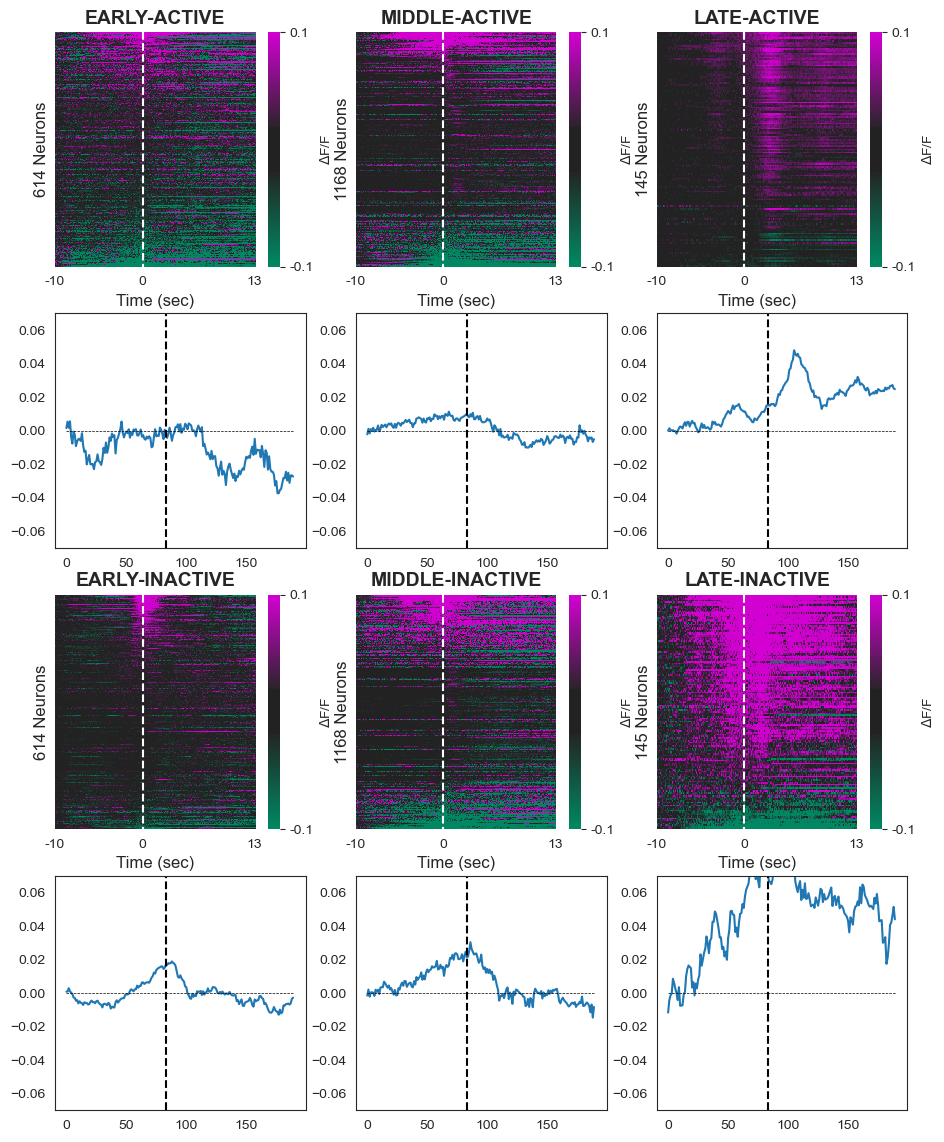

In [24]:
#plot

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(4, 3, figsize=(11, 14))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(sub_early_active[sortresponse_sub_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_sub_early_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_sub_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[1, 0]
ax.plot(sub_early_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# early inactive plots (sorted to active plot)
ax = axs[2, 0]

#filtering NaN's
sorted_sub_early_inactive, inactive_sort = filter_NAN(sub_early_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_sub_early_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_sub_early_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_sub_early_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 0]
ax.plot(sub_early_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(sub_middle_active[sortresponse_sub_middle_active, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_sub_middle_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_sub_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 1]
ax.plot(sub_middle_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# middle inactive plots
ax = axs[2, 1]

#filtering NaN's
sorted_sub_middle_inactive, inactive_sort = filter_NAN(sub_middle_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_sub_middle_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_sub_middle_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_sub_middle_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 1]
ax.plot(sub_middle_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# late active plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(sub_late_active[sortresponse_sub_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_sub_late_active, fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_sub_late_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[1, 2]
ax.plot(sub_late_active_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')

# late inactive plots
ax = axs[2, 2]

#filtering NaN's
sorted_sub_late_inactive, inactive_sort = filter_NAN(sub_late_inactive, window_size, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_sub_late_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0", "13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_sub_late_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_sub_late_inactive], '--', linewidth=1.5, color='white')

# line plot
ax = axs[3, 2]
ax.plot(sub_late_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')


## Cluster Analysis

### Creating cluster models

In [ ]:
#import libraries

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
from scipy import interpolate
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

import matplotlib.pyplot as plt

In [ ]:
#combine data across sets
new_active = np.vstack((sorted_early_inactive, sorted_middle_inactive, sorted_late_inactive)) 
print('New active data shape:', new_active.shape)


In [ ]:
#select data that you want to analyze 
populationdata = new_active

print (populationdata.shape, 'array for clustering')

numneurons = populationdata.shape[0]
populationdata_nan_excluded = np.nan*np.ones((1, window_size))

for i in range(numneurons):
    if np.mean(populationdata[i,:]) < 1000:
        populationdata_nan_excluded = np.vstack((populationdata_nan_excluded,populationdata[i]))
populationdata_nan_excluded = populationdata_nan_excluded[1:,:]

print('Original population data shape:', populationdata.shape, '\nNew population data shape:', populationdata_nan_excluded.shape)
    
sortwindow = [pre_window_size, infusionframe] #sort responses between CS+ onset and reward
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]

cmax = 0.1

trial_types = ['Inactive']
    
populationdata = populationdata[:,(pre_window_size - int(3*framerate)):(pre_window_size + int(6*framerate))]

In [ ]:
#plot parameters

plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.labelspacing'] = 0.2
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['lines.scale_dashes'] = False
plt.rcParams['lines.dashed_pattern'] = (2, 1)
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.color'] = 'k'
sns.set_style('ticks')

In [ ]:
#plotting combined data

fig, axs = plt.subplots(2,len(trial_types),figsize=(3.3,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[t].set_title(trial_types[t])
    ax = axs[0]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'},
                yticklabels=False)
    ax.grid(False)
    ax.tick_params(width=0.5)   

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    
        
    ax = axs[1]
    sns.lineplot(data=np.mean(populationdata[sortresponse, t*window_size:(t+1)*window_size], axis=0), dashes=False,
               ax=ax)
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    ax.set_xticks([])
    
axs[0].set_ylabel('%s Neurons' %numneurons)
axs[1].set_ylabel('Mean norm. fluor.')


fig.tight_layout()
fig.subplots_adjust(right=0.82)

print(populationdata.shape)


In [ ]:
load_savedpca_or_dopca = 'dopca' #select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(models, 'PCA_ACQ_NEW.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(models, 'PCA_ACQ_NEW.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
np.save(os.path.join(models, 'PCA_ACQ_NEW_transformed-data.npy'), transformed_data)
transformed_data = np.load(os.path.join(models, 'PCA_ACQ_NEW_transformed-data.npy'))

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
print(x)
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by siplty bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
ax.set_xlim([0,50])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['Inactive'] = (0,0,0) 
# colors_for_key['Inactive'] = (0.5,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey], label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
    ax.axvline(pre_window_size+int(framerate*3), linestyle='--', color='k', linewidth=1.5)
    ax.axhline(0, linestyle='--', color='k', linewidth=0.5)
    #ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction', #FIXME
    #            textcoords='axes fraction', multialignment='center', size='large')
#     if pc >= num_retained_pcs-numcols:
#         ax.set_xticks([0, pre_window_size,
#                        infusionframe, window_size])
#         ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
#                              for a in [0, pre_window_size,
#                                        infusionframe, window_size]])
#     else:
#         ax.set_xticks([])
#         ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from Press (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)


In [ ]:
#clustering

max_n_clusters = 10 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).

#create cluster array based on number of neurons
def cluster_arr(max_num_clusters, num_nuerons):
    arr = []
    num = num_nuerons/max_num_clusters
    iterative = num
    for i in range(max_num_clusters):
        arr.append(int(iterative))
        iterative = iterative + num
    return(arr)

arr = cluster_arr(max_n_clusters, populationdata.shape[0])
print('Cluster array values:', arr)
possible_n_nearest_neighbors = np.array(arr) # This should be selected for each dataset
# appropriately. When 1511 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data. 
# [500, 1000, 1500,  2500, 3000, 3500, 4000, 4500, 5000, 5500]
# [197, 394, 591, 788, 985, 1182, 1379, 1576, 1773, 1970]
      
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters, nn, silhouette_scores[n_clustersidx, nnidx]))

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(models, 'silhouette_scores_ACQ_NEW.pickle'), 'wb') as f:
    pickle.dump(temp, f)   
    

In [ ]:
with open(os.path.join(models, 'silhouette_scores_ACQ_NEW.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = np.load(os.path.join(models, 'PCA_ACQ_NEW_transformed-data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print ('Num clusters:', n_clusters)
print('Num nearest neighbors:', n_nearest_neighbors)

#redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=n_nearest_neighbors)

#different forms of clustering
# model = KMeans(n_clusters=n_clusters, algorithm = 'elkan')
# model = AgglomerativeClustering(n_clusters=n_clusters)

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

#save this optimal clustering model.
with open(os.path.join(models, 'PFC_SA_ACQ_NEWclusteringmodel.pickle'), 'wb') as f:
    pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels

#saving new labels
newlabels = reorder_clusters(model.labels_)

#create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))

colors_for_cluster = [[0.933, 0.250, 0.211],[0.941, 0.352, 0.156],[0.964, 0.572, 0.117],[0.980, 0.686, 0.250],[0.545, 0.772, 0.247],[0.215, 0.701, 0.290],[0, 0.576, 0.270],[0, 0.650, 0.611],[0.145, 0.662, 0.878]]

np.save(os.path.join(models, 'clusterlabels_ACQ_NEW.npy'), newlabels)
##ONLY USE IF YOU WANT TO OVERWRITE EXISTING, SAVED CLUSTERING DATA

In [ ]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this exaplte all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each saplte
    saplte_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine') #FIXME: saptle???

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for sapltes belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            saplte_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 sapltes

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

In [ ]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)

In [ ]:
####This section saves cluster IDs to each FOV Folder for future use. 
####DO NOT RUN/SAVE UNLESS YOU WANT TO OVERWRITE CLUSTER LISTS

cluster_id_list = newlabels
print('cluster id list shape:', cluster_id_list.shape)

cellcounter = 0

##Assign cluster IDs to neurons within early animals of interest
for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(earlybasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
firstcellearly = 0
lastcellearly = cellcounter
print('EARLY:', newlabels[firstcellearly:lastcellearly].shape)

cellcounter = 0

##Assign cluster IDs to neurons within middle animals of interest
for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(middlebasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
firstcellmiddle = 0
lastcellmiddle = cellcounter
print('MIDDLE:', newlabels[firstcellearly:lastcellearly].shape)
       
cellcounter = 0
###Assign cluster IDs to neurons within late animals of interest
for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        aligned_active_lever_data = np.load(os.path.join(latebasedir, animal, fov, "aligned_active_lever_data.npy"))
        numneurons = aligned_active_lever_data.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
firstcelllate = 0
lastcelllate = cellcounter
print('LATE:', newlabels[firstcellearly:lastcellearly].shape)


### Plotting clusters

#### All population data

In [ ]:
#inactive data
early_populationdata = early_inactive
middle_populationdata = middle_inactive
late_populationdata = late_inactive
all_populationdata = np.vstack((early_inactive, middle_inactive, late_inactive))

##active data
#early_populationdata = early_active
#middle_populationdata = middle_active
#late_populationdata = late_active
#all_populationdata = np.vstack((early_active, middle_active, late_active))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)



In [ ]:
#cluster heatmaps

sessions = ['early', 'middle', 'late', 'all'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for c, cluster in enumerate(uniquelabels):
    sortwindow[c] = {}
    if c == 0:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 1:
        sortwindow[c] = [infusionframe+int(1*framerate), -1]
    if c == 2:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 3:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[c][0]:sortwindow[c][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



In [ ]:
#save fig
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_heatmaps.PDF'), format='PDF')
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_heatmaps.PNG'), format='PNG')

fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clusters_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clsters_heatmaps.PNG'), format='PNG')

In [ ]:
#cluster line plots

fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        numneuronsincluster[c] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, c])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numneuronsincluster[c]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


In [ ]:
#save fig
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_polylines.PDF'), format='PDF')
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_polylines.PNG'), format='PNG')

fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clusters_polylines.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clusters_polylines.PNG'), format='PNG')

#### Population data based on lever presses

##### Active clustering

In [57]:
#active data
early_populationdata = early_active
middle_populationdata = middle_active
late_populationdata = late_active
all_populationdata = np.vstack((early_active, middle_active, late_active))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)



Early population num neurons: 2392
Middle population num neurons: 2592
Late population num neurons: 2237
All population num neurons: 7221

Early labels shape: (2392,)
Middle labels shape: (2592,)
Late labels shape: (2237,)
All labels shape: (7221,)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_20624\2982007620.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


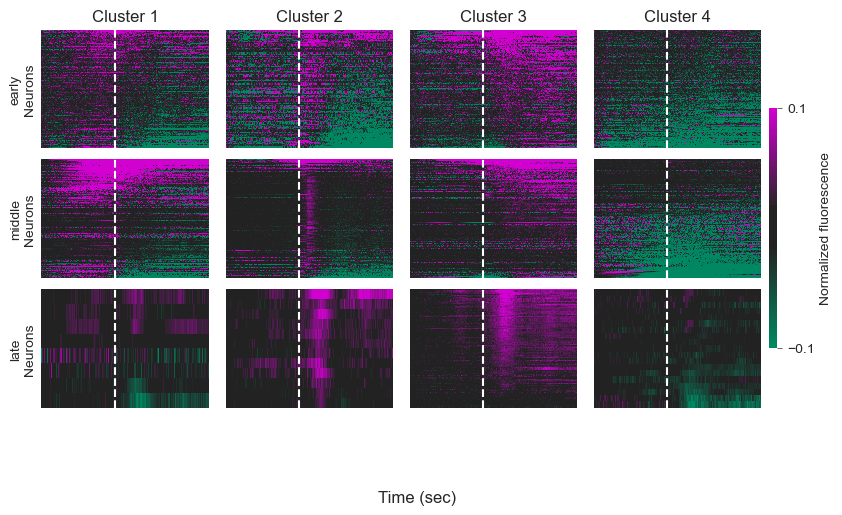

In [58]:
#cluster heatmaps

sessions = ['early', 'middle', 'late'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for c, cluster in enumerate(uniquelabels):
    sortwindow[c] = {}
    if c == 0:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 1:
        sortwindow[c] = [infusionframe+int(1*framerate), -1]
    if c == 2:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 3:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_active_df['Stack index'][np.where(sub_early_active_df['Cluster']==c)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_active_df['Stack index'][np.where(sub_middle_active_df['Cluster']==c)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_active_df['Stack index'][np.where(sub_late_active_df['Cluster']==c)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[c][0]:sortwindow[c][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



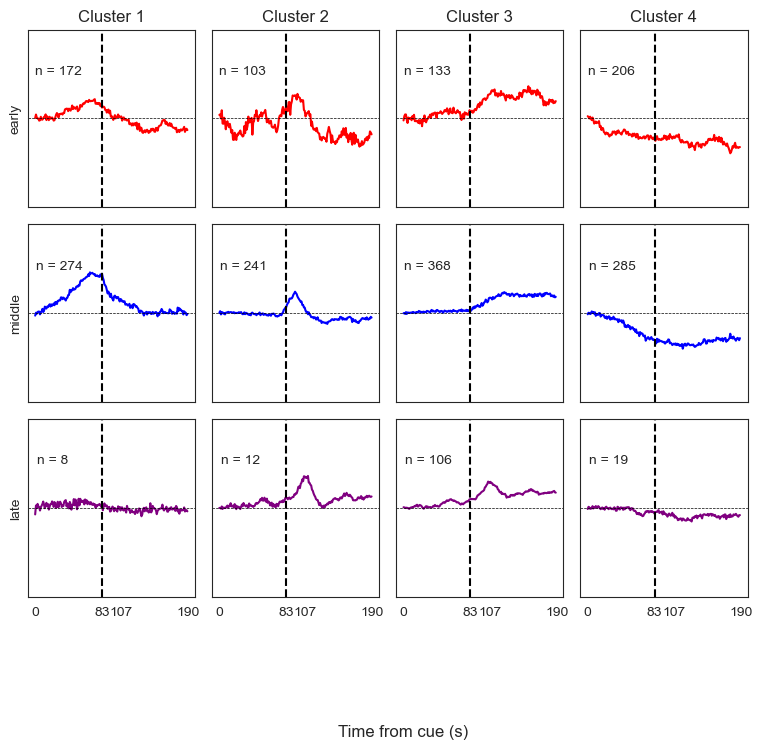

In [59]:
#cluster line plots

fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_active_df['Stack index'][np.where(sub_early_active_df['Cluster']==c)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_active_df['Stack index'][np.where(sub_middle_active_df['Cluster']==c)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_active_df['Stack index'][np.where(sub_late_active_df['Cluster']==c)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[c] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, c])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numneuronsincluster[c]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


##### Inactive clustering

In [60]:
#inactive data
early_populationdata = early_inactive
middle_populationdata = middle_inactive
late_populationdata = late_inactive
all_populationdata = np.vstack((early_inactive, middle_inactive, late_inactive))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)



Early population num neurons: 2392
Middle population num neurons: 2592
Late population num neurons: 2237
All population num neurons: 7221

Early labels shape: (2392,)
Middle labels shape: (2592,)
Late labels shape: (2237,)
All labels shape: (7221,)


C:\Users\jboqu\AppData\Local\Temp\ipykernel_20624\2023204678.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


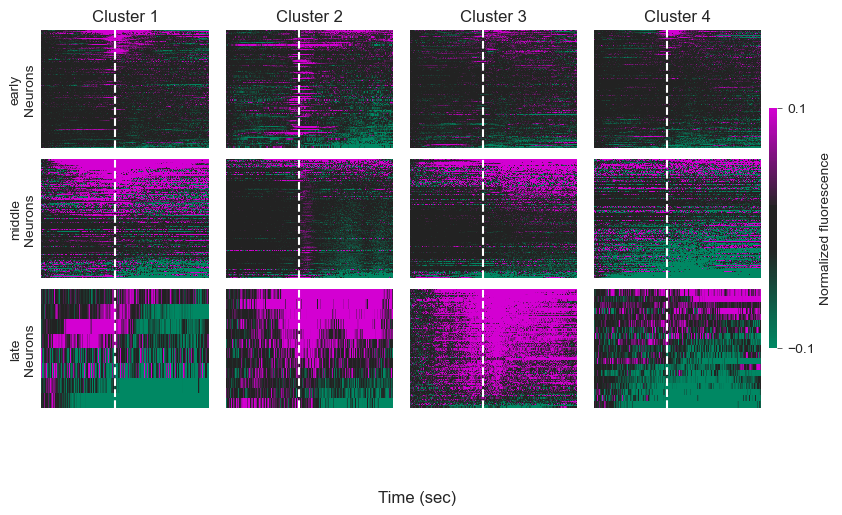

In [61]:
#cluster heatmaps

sessions = ['early', 'middle', 'late'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for c, cluster in enumerate(uniquelabels):
    sortwindow[c] = {}
    if c == 0:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 1:
        sortwindow[c] = [infusionframe+int(1*framerate), -1]
    if c == 2:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 3:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_inactive_df['Stack index'][np.where(sub_early_inactive_df['Cluster']==c)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_inactive_df['Stack index'][np.where(sub_middle_inactive_df['Cluster']==c)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_inactive_df['Stack index'][np.where(sub_late_inactive_df['Cluster']==c)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[c][0]:sortwindow[c][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



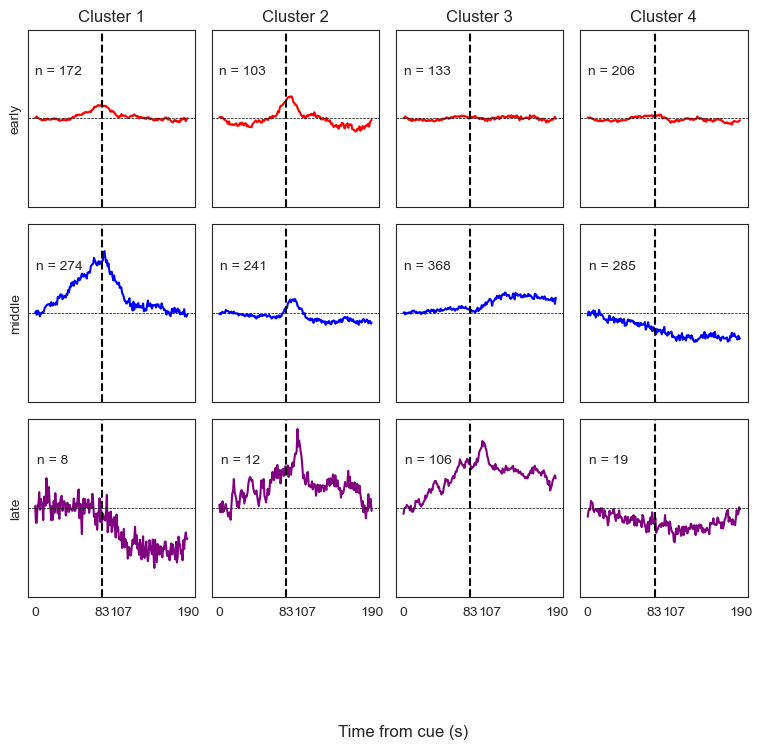

In [62]:
#cluster line plots

fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_inactive_df['Stack index'][np.where(sub_early_inactive_df['Cluster']==c)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_inactive_df['Stack index'][np.where(sub_middle_inactive_df['Cluster']==c)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_inactive_df['Stack index'][np.where(sub_late_inactive_df['Cluster']==c)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[c] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, c])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numneuronsincluster[c]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


## Multivoxel Pattern Analysis *(decoding)*

In [ ]:
#import libraries

import subprocess
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
#various methods

def binaryclassifier(y, X):
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(SVC(), hyperparameters, cv=10)
    if np.any(np.isnan(X)):
        accuracy=np.nan
        print ('nan detected in single neuron! within ', fov)
    else:
        clf.fit(X, y)
        accuracy = clf.best_score_
    return accuracy

def svmregression(y, X):
    hyperparameters = {'kernel': ['rbf'], 'C': np.logspace(-3, 3, 5),
                      'epsilon': np.logspace(-3, 3, 5),
                      'gamma': np.logspace(-5, 5, 10)}
    clf = GridSearchCV(SVR(), hyperparameters, cv=10)
    if np.all(np.isnan(X)):
        R2=np.nan
    else:
        clf.fit(X, y)
        """y_pred = clf.predict(X)
        plt.plot(y,y_pred,'ko')"""
        R2 = clf.best_score_
    #reference for 10-fold cross-validation http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf
    return R2

In [ ]:
###DECODING. Note: this takes time (e.g., ~45 minutes for 3500 neurons). Be sure your parameters below (~line 73) are what you want

groups = ['Early','Middle', 'Late'] ###INSERT YOUR GROUPS (E.G., EARLY AND LATE LEARNING)
session_analysis_split_by_ensemble = ['Yes'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['Neuron', 'Trial'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 3 ###SET TO NUMBER OF CLUSTERS

# late_animals_of_interest = ['PNAC-JO1']

baseline = [1, 8]  ###These variables are for assigning neuronal data epochs
leverresponse = [pre_window_size-9, pre_window_size-1]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

datadir=0
for group in groups:
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}
    classification_accuracy[group]['session'] = {}
    classification_accuracy[group]['session']['shuffled'] = {}
    classification_accuracy[group]['session']['unshuffled'] = {}
    
    if group == 'CueRein':
        animals_of_interest = early_animals_of_interest   
    if group == 'CueRein':
        animals_of_interest = middle_animals_of_interest
        if session_analysis_split_by_ensemble == ['Yes']:
            for c, cluster in enumerate(uniquelabels):
                classification_accuracy[group]['session']['shuffled'][c] = {}
                classification_accuracy[group]['session']['unshuffled'][c] = {}

    numneuronstillnow = 0
    for animal in animals_of_interest:
        fovs = next(os.walk(os.path.join(basedir, group, animal)))[1]
        for fov in sorted(fovs):
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'CueRein':
                cluster_id_list_fov = np.load(os.path.join(basedir, group, animal, fov, fov+'cluster_list_per_fov.npy'))
            temp1, temp2, activetrials, temp4, framerate = analyze_single_session(os.path.join(basedir, group, animal, fov),
                                                            window_size, pre_window_size)
            
            ###THIS SECTION DELETES ANY TRIALS WITH NANs
            for i in reversed(range(activetrials.shape[0])): ###reversed to prevent deletion from messing up indexing
                if np.isnan(np.mean(activetrials[i,:,:])):
                    activetrials = np.delete(activetrials, i, axis = 0)

            ###THIS SECTION ALIGNS DATA FOR DECODING        
            numtrials = activetrials.shape[0]
            numsapltes = activetrials.shape[1]
            numneuronsinfov = activetrials.shape[2]

            baseline_active = np.nan*np.ones((numtrials,numneuronsinfov))
            response_active = np.nan*np.ones((numtrials,numneuronsinfov))

            activeflag = np.hstack((np.zeros((numtrials)), np.ones((numtrials))))
            
            for neuron in range(numneuronsinfov):
                baseline_active[:,neuron] = np.nanmean(activetrials[:,baseline[0]:baseline[1],neuron], axis=1)
                response_active[:,neuron] = np.nanmean(activetrials[:,leverresponse[0]:leverresponse[1],neuron], axis=1)
                
                ###CHANGE THESE VARIABLES TO ADJUST WHAT YOU ARE DECODING AND ENSURE IT ALIGNS WITH YOUR FLAGS
                neuralactivity_trialtype = np.vstack((baseline_active, response_active)) ###FOR COMPARING TRIAL TYPES
                
               ###TRIAL DECODING IN SINGLE NEURONS
                if session_analysis_split_by_ensemble == ['No'] and decoding == ['Neuron','Trial']:
                    classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = \
                        binaryclassifier(activeflag, np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))

                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag,\
                                np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))
                    classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = \
                        shuffledresults
            
            ###TRIAL DECODING BY SESSION
            if session_analysis_split_by_ensemble == ['No'] and decoding == ['Session','Trial']:
                    classification_accuracy[group]['session']['unshuffled'][fov] = \
                        binaryclassifier(activeflag,neuralactivity_trialtype)                                                                           
                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, neuralactivity_trialtype)
                    classification_accuracy[group]['session']['shuffled'][fov] = shuffledresults

            
            ###TRIAL DECODING BY SESSION & ENSEMBLE
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'LateAcq' and decoding == ['Session', 'Trial']:
                for c, cluster in enumerate(uniquelabels):
                    if np.count_nonzero(cluster_id_list_fov==c) > 1:
                        temp = np.squeeze(neuralactivity_trialtype[:, np.where(cluster_id_list_fov==cluster)])
                        classification_accuracy[group]['session']['unshuffled'][c][fov] = \
                            binaryclassifier(activeflag,temp)                                                             
                        shuffledresults = np.nan*np.ones((numshuffles,))
                        for shuffleid in range(numshuffles):
                            shuffled_flag = np.random.permutation(activeflag)
                            shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, temp)
                        classification_accuracy[group]['session']['shuffled'][c][fov] = shuffledresults

            numneuronstillnow += numneurons
